C:\Users\jpate\AppData\Local\Temp\ipykernel_17756\1182735429.py:31: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').sum()


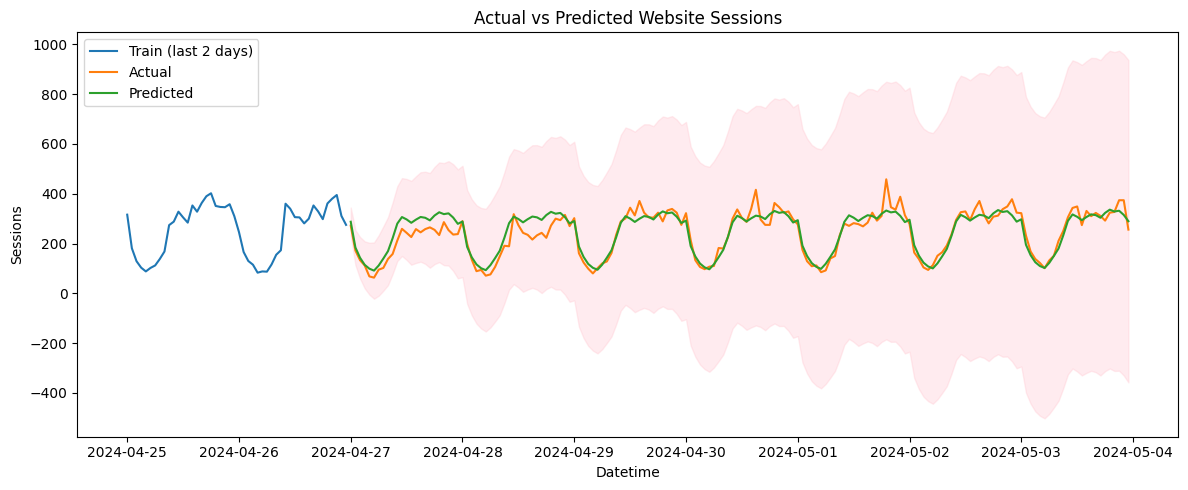

✅ MAE: 26.06
✅ RMSE: 34.45
✅ MAPE: 12.30%


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the file (adjust filename if needed)
df_raw = pd.read_csv("data-export.csv", skiprows=1)

# Rename relevant columns
df_raw.columns = [
    "Channel", "Datetime", "Users", "Sessions", "Engaged Sessions",
    "Avg Engagement Time", "Engaged Sessions/User",
    "Events/Session", "Engagement Rate", "Event Count"
]

# Convert 'Datetime' to datetime format from 'YYYYMMDDHH'
df_raw['Datetime'] = pd.to_datetime(df_raw['Datetime'], format="%Y%m%d%H")

# Convert Sessions to numeric (if not already)
df_raw['Sessions'] = pd.to_numeric(df_raw['Sessions'], errors='coerce')

# Drop rows with missing sessions
df = df_raw[['Datetime', 'Sessions']].dropna()

# Set datetime index
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

# Optional: Resample hourly (if duplicates exist, sum)
df = df.resample('H').sum()

# Train-test split: last 7 days
train = df.iloc[:-24*7]
test = df.iloc[-24*7:]

# SARIMA(1,1,0)(1,1,1)[24]
model = sm.tsa.statespace.SARIMAX(train,
                                  order=(1, 1, 0),
                                  seasonal_order=(1, 1, 1, 24),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
results = model.fit()

# Predict
pred = results.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
pred_mean = pred.predicted_mean
conf_int = pred.conf_int()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(train.index[-48:], train['Sessions'][-48:], label='Train (last 2 days)')
plt.plot(test.index, test['Sessions'], label='Actual')
plt.plot(pred_mean.index, pred_mean, label='Predicted')
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Actual vs Predicted Website Sessions')
plt.xlabel('Datetime')
plt.ylabel('Sessions')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation metrics
mae = mean_absolute_error(test['Sessions'], pred_mean)
rmse = np.sqrt(mean_squared_error(test['Sessions'], pred_mean))
mape = np.mean(np.abs((test['Sessions'] - pred_mean) / test['Sessions'])) * 100

print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE: {mape:.2f}%")
